Action items
* Check tsne loss
* Do you need a more specific SentenceTransformer?
* How many nearby neighbors do you have to train on? Maybe the dataset is just too scattered. Let's say you have only 3 examples to train on. Even if you apply regularization, most likely that's not enough samples to train on.
* Another question is - rouge is much worse on the validation set. In a general sense, this may be okay, but in a more specific sense, for this dataset, I think it often means incorrect information.
    * Check rouge distribution?
    * Yeah, even for the training and validation samples with closest distance, the inference is not good for validation
        * Sanity-check the text for fracture or broken to see if there are any other close examples
* There are also samples that contain almost no information
* Check for nearest samples across the entire dataset (not just train)

In [14]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances

In [2]:
ds = load_dataset("ryanwtsai/MTS_Dialogue-Clinical_Note_TrainValTestSplit")
ds

DatasetDict({
    train: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 1040
    })
    val: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 132
    })
    test: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 128
    })
})

In [3]:
df = {key: pd.DataFrame(value) for key, value in ds.items()}

In [4]:
# model = SentenceTransformer("all-mpnet-base-v2") # max seq len = 384
model = SentenceTransformer("all-distilroberta-v1")

C:\ProgramData\anaconda3\envs\env_dl_cv_transformer_sentpiece\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Encodings

In [5]:
threshold = model.max_seq_length
for key in df:
    df[key] = df[key].loc[df[key]['length'] <= threshold, :]
    df[key]['output_length'] = df[key]['labels'].apply(lambda x: len(x))

In [6]:
# for key in df:
#     print(key + ":")
#     print(df[key]['length'].describe())
#     print(df[key]['output_length'].describe())
#     print("-------------------------------------------------")

In [7]:
embeddings = {key: model.encode(list(df[key]['dialogue'])) for key in df}
embeddings_out = {key: model.encode(list(df[key]['section_text'])) for key in df}

In [8]:
num_samples = {key: embeddings[key].shape[0] for key in embeddings}
for key in embeddings:
    print(f"{key}: {embeddings[key].shape}, {embeddings_out[key].shape}")
print(num_samples)

train: (998, 768), (998, 768)
val: (127, 768), (127, 768)
test: (121, 768), (121, 768)
{'train': 998, 'val': 127, 'test': 121}


In [9]:
embeddings_all = np.concatenate((embeddings['train'], embeddings['val'], embeddings['test']))
embeddings_out_all = np.concatenate((embeddings_out['train'], embeddings_out['val'], embeddings_out['test']))
print(embeddings_all.shape)
print(embeddings_out_all.shape)

(1246, 768)
(1246, 768)


In [10]:
tsne = TSNE(perplexity=10)
embeddings_tsne = tsne.fit_transform(embeddings_all)
kl_div = tsne.kl_divergence_
embeddings_out_tsne = tsne.fit_transform(embeddings_out_all)
kl_div_out = tsne.kl_divergence_
print(embeddings_tsne.shape)
print(embeddings_out_tsne.shape)
print(kl_div)
print(kl_div_out)

(1246, 2)
(1246, 2)
1.4594650268554688
1.3738270998001099


In [11]:
embeddings_tsne_train = embeddings_tsne[:num_samples['train'], :]
embeddings_tsne_val = embeddings_tsne[num_samples['train']:num_samples['train']+num_samples['val'], :]
embeddings_tsne_test = embeddings_tsne[num_samples['train']+num_samples['val']:, :]
embeddings_out_tsne_train = embeddings_out_tsne[:num_samples['train'], :]
embeddings_out_tsne_val = embeddings_out_tsne[num_samples['train']:num_samples['train']+num_samples['val'], :]
embeddings_out_tsne_test = embeddings_out_tsne[num_samples['train']+num_samples['val']:, :]
print(f"embeddings_tsne_train.shape = {embeddings_tsne_train.shape}")
print(f"embeddings_tsne_val.shape = {embeddings_tsne_val.shape}")
print(f"embeddings_tsne_test.shape = {embeddings_tsne_test.shape}")
print(f"embeddings_out_tsne_train.shape = {embeddings_out_tsne_train.shape}")
print(f"embeddings_out_tsne_val.shape = {embeddings_out_tsne_val.shape}")
print(f"embeddings_out_tsne_test.shape = {embeddings_out_tsne_test.shape}")

embeddings_tsne_train.shape = (998, 2)
embeddings_tsne_val.shape = (127, 2)
embeddings_tsne_test.shape = (121, 2)
embeddings_out_tsne_train.shape = (998, 2)
embeddings_out_tsne_val.shape = (127, 2)
embeddings_out_tsne_test.shape = (121, 2)


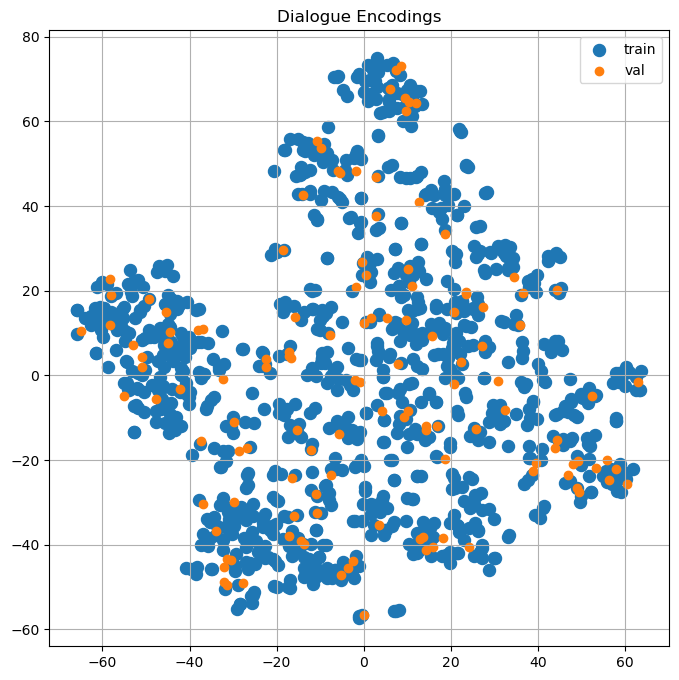

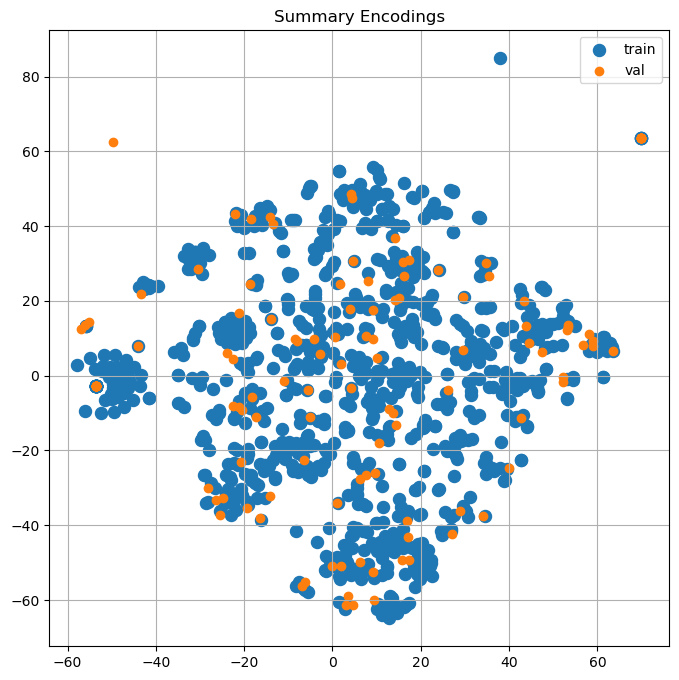

In [13]:
plt.figure(figsize=(8,8))
plt.scatter(embeddings_tsne_train[:, 0], embeddings_tsne_train[:, 1], s=75, label="train")
plt.scatter(embeddings_tsne_val[:, 0], embeddings_tsne_val[:, 1], label="val")
# plt.scatter(embeddings_tsne_test[:, 0], embeddings_tsne_test[:, 1], label="test")
plt.title("Dialogue Encodings")
plt.legend()
plt.grid()

plt.figure(figsize=(8,8))
plt.scatter(embeddings_out_tsne_train[:, 0], embeddings_out_tsne_train[:, 1], s=75, label="train")
plt.scatter(embeddings_out_tsne_val[:, 0], embeddings_out_tsne_val[:, 1], label="val")
# plt.scatter(embeddings_out_tsne_test[:, 0], embeddings_out_tsne_test[:, 1], label="test")
plt.title("Summary Encodings")
plt.legend()
plt.grid()

In [38]:
def get_closest_training_samples(val, train, metric="euclidean", top_k=5):
    distances = pairwise_distances(val, train, metric=metric)
    nearest_train = np.argsort(distances, axis=1)[:, :top_k]
    nearest_dist = np.take_along_axis(distances, nearest_train, axis=1)

    return nearest_train, nearest_dist

In [40]:
nearest_train, nearest_dist = get_closest_training_samples(embeddings_tsne_val, embeddings_tsne_train)
nearest_train_out, nearest_dist_out = get_closest_training_samples(embeddings_out_tsne_val, embeddings_out_tsne_train)

In [41]:
val_sample = np.argmin(nearest_dist[:, 0])

In [42]:
nearest_dist[val_sample, :]

array([0.04977102, 1.9675803 , 2.3287737 , 2.8962946 , 3.1816497 ],
      dtype=float32)

In [43]:
train_samples = nearest_train[val_sample, :]

In [44]:
train_samples

array([810,  72, 982, 925, 523], dtype=int64)

In [46]:
train_samples_out = nearest_train_out[val_sample, :]
train_samples_out

array([810, 353, 860, 220, 449], dtype=int64)

In [45]:
print(f"Val sample = {val_sample}, train sample = {train_samples[0]}")

Val sample = 63, train sample = 810


In [34]:
print(df['val'].iloc[val_sample, :]['dialogue'])

Doctor: Good morning, young man. Are these your parents?
Patient: Yes. 
Doctor: Good, can you tell me more about your son, please? 
Guest_family_1: Well, he's five now, and he fell onto his right arm on December fifth two thousand seven.
Doctor: After he fell, how was he treated? 
Guest_family_1: We went to the E D right after he fell, and they said he had complete fractures of both bones in the arm. 
Doctor: Yes, I see that here, he also has shortening bayonet apposition. 
Guest_family_1: What can we do for this? 
Doctor: There's actually a few options here. First we can cast it and see how he heals, generally, children heal up very well from fractures. 
Guest_family_1: That's good, we like that option more than any kind of surgery. 
Doctor: However, surgery is also an option here as well. 
Guest_family_1: Yeah, to be completely sure we fix this, I think we should opt for the surgery, what do you think, honey?
Guest_family_2: Yes, I agree. What are the risks of infection for this surg

In [35]:
print(df['train'].iloc[train_samples[0], :]['dialogue'])

Doctor: Remind me, how did he hurt himself?
Guest_family_1: He was riding quads on October tenth two thousand seven when he got thrown off. 
Doctor: Yes, and we did O R I F on his fracture dislocation of the left elbow. 
Guest_family_1: Yes, he also fractured the neck of his right glenoid, um, if I remember correctly. 
Doctor: Which hand does he write with? 
Guest_family_1: He writes with his right hand. 
Doctor: Okay. That fracture appears to have healed very well; kids generally heal pretty well. How does it feel today? 
Guest_family_1: Yes, he's only ten. He's been pretty stiff, so he's been going to P T, and using his Dynasplint.
Doctor: That's good that he is already in P T. His left elbow fracture is healed, so we should do another surgery in order to remove that hardware. That may help decrease some of the irritation with elbow extension. He looks neurologically intact in terms of movement and reflexed in his wrist and hand. 
Guest_family_1: Yes, I agree. What is the risk of inf

In [36]:
print(df['val'].iloc[val_sample, :]['section_text'])

Symptoms: refracture of right forearm
Diagnosis: complete fractures of both bones in right arm, shortening bayonet apposition
History of Patient: fell onto right arm on December 5, 2007
Plan of Action: surgery for closed reduction and pinning, with risks including anesthesia, infection, bleeding, changes in sensation and motion of extremity, hardware failure, need for later hardware removal, cast tightness



In [37]:
print(df['train'].iloc[train_samples[0], :]['section_text'])

Symptoms: N/A
Diagnosis: N/A
History of Patient: 10-year-old right-hand dominant male threw himself off a quad on 10/10/2007, underwent open reduction and internal fixation of left elbow fracture dislocation, sustained nondisplaced right glenoid neck fracture, experiencing postoperative stiffness treated with physical therapy and Dynasplint, neurologically intact distally
Plan of Action: Surgery recommended for hardware removal from left elbow to decrease irritation with elbow extension, risks discussed include anesthesia, infection, bleeding, changes in sensation and motion of extremities, failure to remove hardware, failure to relieve pain, continued postoperative stiffness; parents agreed to the plan



In [47]:
print(f"Val sample ID = {df['val'].iloc[val_sample, :]['ID']}")
print(f"Train sample ID = {df['train'].iloc[train_samples[0], :]['ID']}")

Val sample ID = 209
Train sample ID = 727


In [48]:
# Only the first sample seems relevant - that matches with the nearest distances
for train_sample in train_samples:
    print(df['train'].iloc[train_sample, :]['section_text'])
    print("-------------------------------------------------")

Symptoms: N/A
Diagnosis: N/A
History of Patient: 10-year-old right-hand dominant male threw himself off a quad on 10/10/2007, underwent open reduction and internal fixation of left elbow fracture dislocation, sustained nondisplaced right glenoid neck fracture, experiencing postoperative stiffness treated with physical therapy and Dynasplint, neurologically intact distally
Plan of Action: Surgery recommended for hardware removal from left elbow to decrease irritation with elbow extension, risks discussed include anesthesia, infection, bleeding, changes in sensation and motion of extremities, failure to remove hardware, failure to relieve pain, continued postoperative stiffness; parents agreed to the plan

-------------------------------------------------
Symptoms: N/A
Diagnosis: acute on chronic right slipped capital femoral epiphysis
History of Patient: presented in November
Plan of Action: underwent in situ pinning, screw exchange discussed

-------------------------------------------

In [49]:
nearest_all, nearest_dist_all = get_closest_training_samples(embeddings_tsne_val, embeddings_tsne)

In [50]:
nearest_all[val_sample, :]

array([1061,  810, 1062,   72,  982], dtype=int64)

In [51]:
nearest_dist_all[val_sample, :]

array([0.        , 0.04977102, 0.95473933, 1.9675803 , 2.3287737 ],
      dtype=float32)

In [59]:
print(f"ID: {df['val'].iloc[val_sample+1, :]['ID']}")
print(f"Subject: {df['val'].iloc[val_sample+1, :]['section_header']}")
print('')
print(df['val'].iloc[val_sample+1, :]['dialogue'])
print('')
print(df['val'].iloc[val_sample+1, :]['section_text'])

ID: 649
Subject: GENHX

Doctor: Hello. How are you both doing today? 
Guest_family: We're doing great. The E D told us to come here. We're here to see if we could get the stuff in his leg taken out. 
Doctor: I see. Did he have a fracture before? 
Guest_family: Yeah, he did. Here's the report from the surgery from October two thousand and seven. 
Doctor: Great. Let me take a look. It looks like he had a distracted left lateral condyle fracture. He then underwent screw compression to fix the fracture, correct? 
Guest_family: That's correct. 
Doctor: Perfect. So, now we just have to remove the hardware that was used to fix the fracture, right? 
Guest_family: Yeah, that's correct. What are the risks of the surgery? 
Doctor: The risks include the risk of anesthesia, infection, bleeding, changes in sensation and motion of extremity, failure of removal of hardware, failure to relieve pain or improved range of motion.  
Guest_family: Oh, wow. That's a lot. Could you go over the benefits?
Docto